In [1]:
import numpy as np
from utility import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

/home/bzr0014/anaconda3/envs/kerasGpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bzr0014/anaconda3/envs/kerasGpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bzr0014/anaconda3/envs/kerasGpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bzr0014/anaconda3/envs/kerasGpu

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/kerasGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
pylab.rcParams['figure.figsize'] = (10, 9)
def threshold(img, low, high, label):
    w, h, d = img.shape
    masks = []
    for i in range(3):
        masks.append(img[:, :, i] <= high[i])
        masks.append(img[:, :, i] >= low[i])
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones((w, h))
    for m in masks:
        mask *= m   
    return(mask * label)
def preprocess_label(label):
    m1 = threshold(label, [0, 0, 0], [1, 1, 255], 1)
    m2 = threshold(label, [240, 0, 0], [255, 30, 255], 2)
    m3 = threshold(label, [255, 255, 255], [255, 255, 255], 3)
    m = m1 + m2 + m3
    m = cv2.erode(m, np.ones((3, 3)))
    return m
def preprocess_image(img, n=5, k=3):
    if len(img.shape) == 3:
        img_gray = img.mean(axis=2)
    masks = []
    masks.append(img[:, :, 0] >= 240)
    masks.append(img[:, :, 1] <= 200)
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones_like(img_gray)
    for m in masks:
        mask *= m

    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(mask,kernel,iterations = 1)

    n = 10
    N = n * 2  +1
    k = 3
    kernel = np.ones((N, N), dtype='float32') / (N * N - k*k)
    kernel[n+1-k//2:n+2+k//2, n:n+3] = 0
    kernel = kernel.reshape(1, N*N)
    indices = np.where(dilation)
    new_img = img_gray.copy()
    for i in range(5):
        for i, j in zip(indices[0], indices[1]):
            new_img[i, j] = np.dot(kernel, new_img[i-n:i+n+1, j-n:j+n+1].reshape(N*N, 1))
            #new_img[i, j] = np.median(new_img[i-n:i+n+1, j-n:j+n+1])

    new_img = cv2.GaussianBlur(new_img,(9,9),0)
    #new_img = cv2.medianBlur(new_img, 9)
    return new_img

In [9]:
neighSize = 21
img_shape = (200, 100)
def convert_images(new_img, m, neighSize=neighSize, img_shape=img_shape):
    original = cv2.resize(new_img, img_shape)
    marks = cv2.resize(m, img_shape)
    w, h = original.shape
    numNeighInRows = w - neighSize + 1
    X = []
    y = []
    for i in range(w-neighSize+1):
        X_tmp = []
        y_tmp = []
        for j in range(h-neighSize+1):
            X_tmp.append(original[i:i+neighSize, j:j+neighSize])
            y_tmp.append(marks[i:i+neighSize, j:j+neighSize])
        X.append(X_tmp)
        y.append(y_tmp)

    #assert(X.shape == (w-neighSize+1, h-neighSize+1, neighSize, neighSize))
    #assert(X.shape == y.shape)
    return X, y


(1000, 1391)


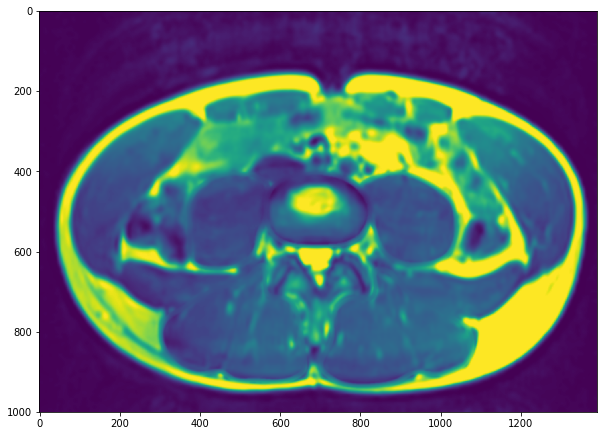

(35084,)


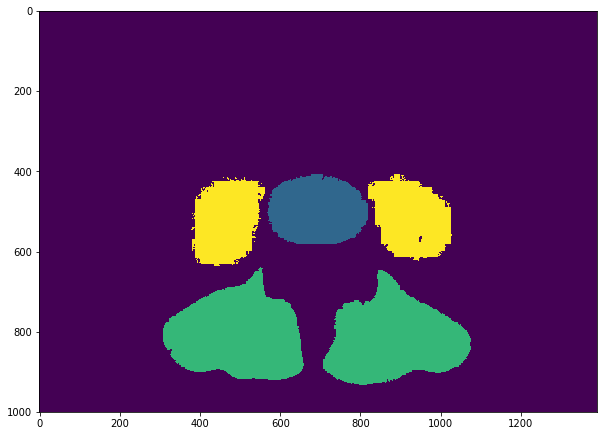

In [30]:
original = preprocess_image(plt.imread('/home/bzr0014/git/sesek2/Behnam Files/original/M010-MFC.tif')[200:-200, 300:-300])
print(original.shape)
imshow(original)
plt.show()
marks = preprocess_label(plt.imread('/home/bzr0014/git/sesek2/Behnam Files/tagged/M010-MFC.jpg')[200:-200, 300:-300])
plt.imshow(marks)
print(np.where(marks == 1)[0].shape)

In [31]:
X, y = convert_images(original, marks)
X = np.array(X)
X = (X-X.mean())/X.std()
y = np.array(y)
print('shape of X: ', X.shape)
print('shape of y: ', y.shape)

shape of X:  (80, 180, 21, 21)
shape of y:  (80, 180, 21, 21)


(101, 201)
(101, 201)


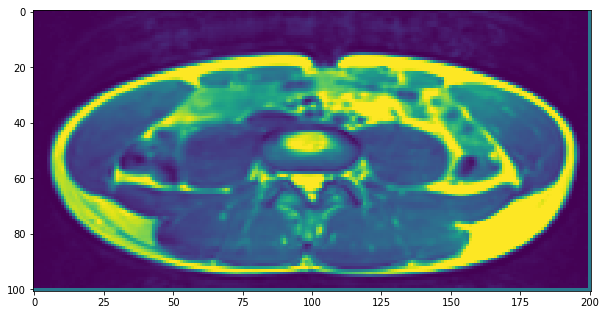

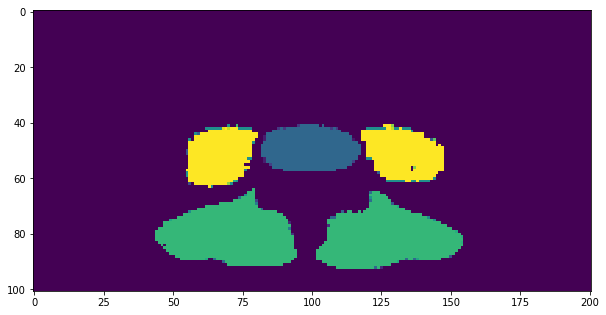

In [33]:
def reconstruct(y):
    a, b, c, d = y.shape
    reconstructed = np.zeros((a+c, b+d))
    for i in range(a):
        for j in range(b):
            reconstructed[i:i+neighSize, j:j+neighSize] = y[i, j]
    return reconstructed
y_reconstructed = reconstruct(y)
X_reconstructed = reconstruct(X)
print(y_reconstructed.shape)
print(X_reconstructed.shape)
assert(y_reconstructed.shape == X_reconstructed.shape)
imshow(X_reconstructed)
plt.show()
imshow(y_reconstructed)

In [34]:
print(X.shape)
X_train = X.reshape(-1, neighSize, neighSize, 1)
y_train = y.reshape(-1, neighSize, neighSize)[:, neighSize//2, neighSize//2]
#numData = X_train.shape[0]
#train_size = int(numData * .8)
#X_val = X_train[train_size:]
#y_val = y_train[train_size:]
#X_train = X_train[:train_size]
#y_train = y_train[:train_size]

(80, 180, 21, 21)


In [35]:
print(X_train.shape)
print(y_train.shape)
#print(X_val.shape)
#print(y_val.shape)

(14400, 21, 21, 1)
(14400,)


In [38]:

layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5

n_outputs = 4
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 1620
Tensor("skip/concat:0", shape=(?, 21, 21, 21), dtype=float32)


In [39]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)


In [40]:
n_epochs = 1000
batch_size = 100
train_indicies = np.arange(X_train.shape[0])

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        np.random.shuffle(train_indicies)
        for iteration in range(int(math.ceil(X_train.shape[0]/batch_size))):
            start_idx = (iteration*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            X_batch = X_train[idx, :]
            y_batch = y_train[idx]
            sess.run(training_op, feed_dict={X_tf: X_batch, y_tf: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        #acc_test = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        loss_val = loss.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            check_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1       
        print(epoch, "Train accuracy:", acc_train, "loss:", loss_val)
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
        save_path = saver.save(sess, "./my_trace_model")
        
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.90520835 loss: 0.23661193
1 Train accuracy: 0.96166664 loss: 0.1191646
2 Train accuracy: 0.983125 loss: 0.06888043
3 Train accuracy: 0.98333335 loss: 0.059307013


KeyboardInterrupt: 

In [41]:
with tf.Session() as sess:
    saver.restore(sess, './my_trace_model')
    X_all = X.reshape(-1, neighSize, neighSize, 1)
    output = []
    for i in arange(0, X_all.shape[0], 100):
        output.append(logits.eval(feed_dict={X_tf:X_all[i:i+100]}))
predicted = np.array(output[:-1]).reshape(-1, 2)
predicted = np.vstack((predicted, output[-1]))
predicted.shape
predicted = np.exp(predicted)
predicted = predicted[:, 1] / np.sum(predicted, axis=1)
print(predicted.shape)
print(predicted.min())
print(predicted.max())
predicted = (predicted.reshape(160, 236))

INFO:tensorflow:Restoring parameters from ./my_trace_model


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [43]:
with tf.Session() as sess:
    saver.restore(sess, './my_trace_model')
    output = y_prob.eval(feed_dict={X_tf:X_train})
    print(output.shape)
    
predicted = output[:, 1] / np.sum(output, axis=1)
print(predicted.shape)
print(predicted.min())
print(predicted.max())
predicted = (predicted.reshape(80, 180))

INFO:tensorflow:Restoring parameters from ./my_trace_model
(14400, 4)
(14400,)
1.8847428e-18
0.99832815


(80, 180)

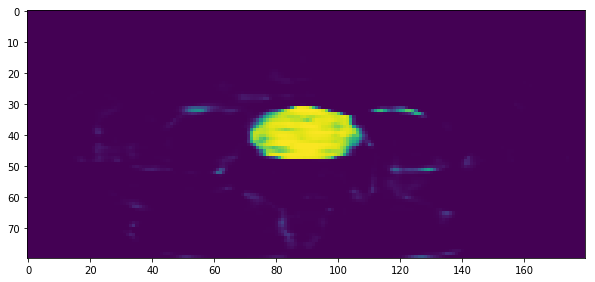

In [44]:
imshow(predicted)
predicted.shape

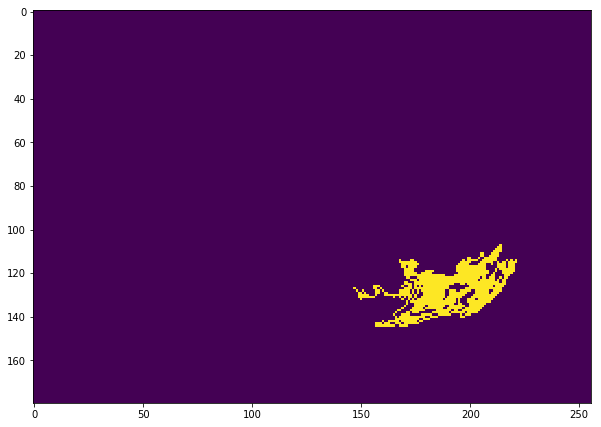

In [161]:
traces = np.zeros_like(original)
img = np.copy(original)
marked_pixels = np.where(marks > 0)
pix_index = np.random.randint(0, len(marked_pixels[0]))
i, j = np.array([marked_pixels[0][pix_index], marked_pixels[1][pix_index]])
for count in range(1000):
    traces[i, j] = 255
    neighbors = np.copy(img[i-1:i+2, j-1:j+2])
    trace_neighbors = np.copy(traces[i-1:i+2, j-1:j+2])
    neighbors[np.where(trace_neighbors == 255)] = -100
    im, jm = np.unravel_index(np.argmax(neighbors), neighbors.shape)
    i, j = (i+im-1, j+jm-1)
imshow(traces)

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bzr0014/anaconda3/envs/te

True

In [3]:
tf.__version__sion__

'1.2.1'

In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))